In [10]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
from scipy.linalg import norm
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pylab as pylab
# params = {'legend.fontsize': 10,
#          'axes.labelsize': 10,
#          'axes.titlesize':10,
#          'xtick.labelsize':10,
#          'ytick.labelsize':10,
#           'axes.titlesize' : 10}
# pylab.rcParams.update(params)
plt.rcdefaults()
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle

In [4]:
def calc_one_zero_error(T,Estimate, ratio = True):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    error = np.sum(~(np.sign(T[np.triu_indices(T.shape[0], k = 1)]) == np.sign(Estimate[np.triu_indices(Estimate.shape[0], k = 1)])))
    if ratio:
        error = error/float(d*(d-1)/2)
    return error

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_precision(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.precision_score(y_true,y_pred)

def calc_recall(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)

def calc_density(prec):
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    # G = nx.fast_gnp_random_graph(300,0.3)
    return nx.density(G)

def calc_roc(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)

# Outer EM test

In [3]:
from sklearn.datasets import make_sparse_spd_matrix
n = 1000
ds = [5, 10, 20, 50, 80, 100, 150, 300, 1000]
#alpha_prob = [0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ] 
d = 50
alpha_prob = 0.7

prec = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))

n = 1000
X = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n, random_state=42)
    
obs_per_graph = 100



0.7575510204081632


In [13]:
start = time.time()
dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, nr_em_its = 10000, nr_admm_its = 3, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.4, tol_em = 1e-6, tol_admm=1e-6)
dg_opt1.fit(X,temporal_penalty="global-reconstruction",  nu = 4, time_index=range(X.shape[0]))
elapsed = time.time()-start

Outer Error 2.00E-6, Inner error 9.67E-7:   1%|▏         | 134/10000 [00:08<10:10, 16.15it/s]


In [5]:
nr_admm_its = [1,2,3,4,5,10, 15]

theta_dict = {i:[] for i in range(len(nr_admm_its))}
time_elapsed = []
l1_error = []
zo_error = []
f_error = []
nr_its = []

for i,nr_admm in enumerate(nr_admm_its):
    print(nr_admm)

    elapsed_tmp = []
    nr_its_tmp = []
    l1_tmp = []
    zo_tmp = []
    f_tmp = []
    for j in range(5):

        start = time.time()
        dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, nr_em_its = 10000, nr_admm_its = nr_admm, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.4, tol_em = 1e-6, tol_admm=1e-6)
        dg_opt1.fit(X,temporal_penalty="global-reconstruction",  nu = 4, time_index=range(X.shape[0]))
        elapsed = time.time()-start

        elapsed_tmp.append(elapsed)
        nr_its_tmp.append(dg_opt1.iteration)

        l1_error_val = np.mean([norm(dg_opt1.theta[k] - prec, ord = 1)/norm(prec,ord=1)  for k in range(len(dg_opt1.theta))])
        l1_tmp.append(l1_error_val)
        f_error_val = np.mean([norm(dg_opt1.theta[k] - prec, ord = 'fro')/norm(prec,ord='fro')  for k in range(len(dg_opt1.theta))])
        f_tmp.append(f_error_val)
        zo_error_val = np.mean([calc_one_zero_error(prec,dg_opt1.theta[k])  for k in range(len(dg_opt1.theta))])
        zo_tmp.append(zo_error_val)



    theta_dict[i] = dg_opt1.theta
    time_elapsed.append(elapsed_tmp)
    nr_its.append(nr_its_tmp)
    l1_error.append(l1_tmp)
    f_error.append(f_tmp)
    zo_error.append(zo_tmp)





1


Outer Error 1.01E-6, Inner error 1.01E-6:   6%|▌         | 620/10000 [00:09<02:27, 63.76it/s]


2


Outer Error 2.03E-6, Inner error 9.93E-7:   3%|▎         | 325/10000 [00:08<04:27, 36.14it/s]


3


Outer Error 2.04E-6, Inner error 9.85E-7:  19%|█▊        | 1851/10000 [01:12<05:19, 25.47it/s]


4


Outer Error 1.90E-6, Inner error 9.10E-7:   3%|▎         | 264/10000 [00:13<08:17, 19.56it/s]


5


Outer Error 1.56E+0, Inner error 3.11E-1: 100%|██████████| 10000/10000 [10:25<00:00, 15.52it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel_outer.py:264: UserWarning: Max EM iterations reached. Tolerance is 1.56E+0
  warnings.warn(f'Max EM iterations reached. Tolerance is {Decimal(self.fro_norm):.2E}')
Outer Error 1.56E+0, Inner error 3.11E-1: 100%|██████████| 10000/10000 [10:25<00:00, 15.99it/s]


10


Outer Error 1.74E-6, Inner error 6.68E-7:   1%|▏         | 140/10000 [00:16<18:57,  8.67it/s]


15


Outer Error 1.64E-6, Inner error 6.28E-7:   2%|▏         | 232/10000 [00:39<27:35,  5.90it/s]


In [40]:
out_dict = {'time_elapsed':time_elapsed, 'nr_admm_its':nr_admm_its, 'l1_error':l1_error, 'zo_error':zo_error, 'f_error':f_error, 'alpha':0.05, 'kappa':0.4, 
'n':n, 'obs_per_graph':obs_per_graph}
import pickle
with open(f'../data/outer_inner/outer_start.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14,5))

ax[0].plot(nr_admm_its, [np.median(time_elapsed[i]) for i in range(len(time_elapsed))])
ax[0].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[0].set_ylabel("Seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xticks([0,5, 10, 15])

ax[1].plot(nr_admm_its,[np.mean(l1_error[i]) for i in range(len(l1_error))], label ='l1')
ax[1].plot(nr_admm_its,[np.mean(zo_error[i]) for i in range(len(zo_error))], label ='Zero-One')
ax[1].plot(nr_admm_its,[np.mean(f_error[i]) for i in range(len(f_error))], label ='Frobenius')
legend = ax[1].legend(title = "Metric",fontsize = 14)
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xticks([0,5, 10, 15])


# Inner EM

In [4]:
nr_admm_its = [1,2,3,4,5,10, 15]

theta_dict = {i:[] for i in range(len(nr_admm_its))}
time_elapsed = []
l1_error = []
zo_error = []
f_error = []
nr_its = []

for i,nr_admm in enumerate(nr_admm_its):
    print(nr_admm)

    elapsed_tmp = []
    nr_its_tmp = []
    l1_tmp = []
    zo_tmp = []
    f_tmp = []
    for j in range(5):

        start = time.time()
        dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 5000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.4, tol = 1e-6)
        dg_opt1.fit(X, nr_workers=1, temporal_penalty="global-reconstruction", lik_type="t", nr_em_itr = nr_admm, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6)
        elapsed = time.time()-start

        elapsed_tmp.append(elapsed)
        nr_its_tmp.append(dg_opt1.iteration)

        l1_error_val = np.mean([norm(dg_opt1.theta[k] - prec, ord = 1)/norm(prec,ord=1)  for k in range(len(dg_opt1.theta))])
        l1_tmp.append(l1_error_val)
        f_error_val = np.mean([norm(dg_opt1.theta[k] - prec, ord = 'fro')/norm(prec,ord='fro')  for k in range(len(dg_opt1.theta))])
        f_tmp.append(f_error_val)
        zo_error_val = np.mean([calc_one_zero_error(prec,dg_opt1.theta[k])  for k in range(len(dg_opt1.theta))])
        zo_tmp.append(zo_error_val)



    theta_dict[i] = dg_opt1.theta
    time_elapsed.append(elapsed_tmp)
    nr_its.append(nr_its_tmp)
    l1_error.append(l1_tmp)
    f_error.append(f_tmp)
    zo_error.append(zo_tmp)





1


  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:109: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")
Error 1.02E-6:   7%|▋         | 366/5000 [00:09<01:54, 40.63it/s]


2


Error 1.01E-6:   7%|▋         | 357/5000 [00:13<02:52, 26.88it/s]


3


Error 1.00E-6:   7%|▋         | 353/5000 [00:15<03:18, 23.39it/s]


4


Error 1.01E-6:   7%|▋         | 351/5000 [00:17<03:45, 20.60it/s]


5


Error 1.02E-6:   7%|▋         | 350/5000 [00:18<04:00, 19.32it/s]


10


Error 1.00E-6:   7%|▋         | 350/5000 [00:22<05:03, 15.34it/s]


15


Error 1.00E-6:   7%|▋         | 350/5000 [00:26<05:47, 13.38it/s]


In [5]:
out_dict = {'time_elapsed':time_elapsed, 'nr_admm_its':nr_admm_its, 'l1_error':l1_error, 'zo_error':zo_error, 'f_error':f_error, 'alpha':0.05, 'kappa':0.4, 
'n':n, 'obs_per_graph':obs_per_graph, 'd':X.shape[1]}
import pickle
with open(f'../data/outer_inner/inner_start.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

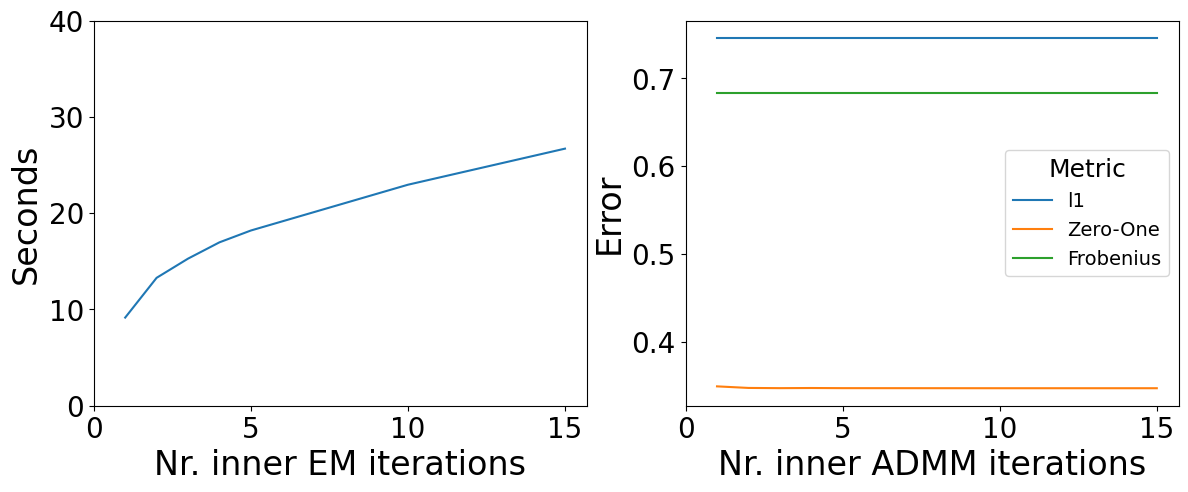

In [7]:
fig, ax = plt.subplots(1,2, figsize = (14,5))

ax[0].plot(nr_admm_its, [np.median(time_elapsed[i]) for i in range(len(time_elapsed))])
ax[0].set_xlabel("Nr. inner EM iterations", fontdict = {'fontsize':24})
ax[0].set_ylabel("Seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xticks([0,5, 10, 15])
ax[0].set_ylim([0, 40])

ax[1].plot(nr_admm_its,[np.mean(l1_error[i]) for i in range(len(l1_error))], label ='l1')
ax[1].plot(nr_admm_its,[np.mean(zo_error[i]) for i in range(len(zo_error))], label ='Zero-One')
ax[1].plot(nr_admm_its,[np.mean(f_error[i]) for i in range(len(f_error))], label ='Frobenius')
legend = ax[1].legend(title = "Metric",fontsize = 14)
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xticks([0,5, 10, 15])


In [11]:
norm(theta_dict[2] - theta_dict[3])

9.526321603737784e-07

# Outer vs Inner

In [7]:
ds = [5, 10, 20, 50, 80, 100, 150, 300]
alpha_prob = [0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alpha = 0.05
kappa = 0.4
tol = 1e-8
n = 1000
obs_per_graph = 100
prec_dict ={}

dens_inner = []
time_inner = []
F_inner = []
zo_inner = []
l1_inner = []

dens_outer = []
time_outer = []
F_outer = []
zo_outer = []
l1_outer = []


for i,d in enumerate(ds):
    print(d)

    prec = make_sparse_spd_matrix(d, alpha=alpha_prob[i], smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    print("\n")

    prec_dict[i] = prec


    X1 = np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
    X = X1



    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
    dg_opt1.fit(X, nr_workers=1, temporal_penalty="global-reconstruction", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6)
    elapsed = time.time()-start
    dens_inner.append(nx.density(G))
    time_inner.append(elapsed)

    zo_inner.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_inner.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 'fro')/norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_inner.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 1)/norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
        
    start = time.time()
    dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, nr_em_its = 10000, nr_admm_its = 1, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.4, tol_em = tol, tol_admm=1e-6)
    dg_opt1.fit(X,temporal_penalty="global-reconstruction",  nu = 4, time_index=range(X.shape[0]))
    elapsed = time.time()-start
    dens_outer.append(nx.density(G))
    time_outer.append(elapsed)

    zo_outer.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_outer.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 'fro')/norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_outer.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 1)/norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))

out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 
'density_inner':dens_inner, 'tol':tol, 'time_inner':time_inner, 'zo_inner':zo_inner, 'F_inner':F_inner, 'l1_inner':l1_inner,
'density_outer':dens_outer, 'tol':tol, 'time_outer':time_outer, 'zo_outer':zo_outer, 'F_inner':F_outer, 'l1_inner':l1_outer,
'ds':ds, 'alpha':alpha, 'kappa':kappa, 'max_iter':5000} 
    

with open(f'../data/outer_inner/outer_inner.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


5




Outer Error 1.00E-8, Inner error 1.00E-8:  14%|█▍        | 1423/10000 [00:02<00:17, 497.08it/s]


10




Outer Error 1.00E-8, Inner error 1.00E-8:  16%|█▋        | 1640/10000 [00:04<00:22, 368.71it/s]


20




Outer Error 1.00E-8, Inner error 1.00E-8:   5%|▍         | 479/10000 [00:02<00:41, 228.97it/s]


50




Outer Error 1.01E-8, Inner error 1.01E-8:   6%|▌         | 563/10000 [00:08<02:25, 64.73it/s]


80




Outer Error 1.00E-8, Inner error 1.00E-8:   8%|▊         | 775/10000 [00:31<06:10, 24.89it/s]


100




Outer Error 1.01E-8, Inner error 1.01E-8:   7%|▋         | 699/10000 [01:00<13:22, 11.58it/s]


150




Outer Error 1.01E-8, Inner error 1.01E-8:   7%|▋         | 710/10000 [02:59<39:13,  3.95it/s]


300




Outer Error 1.03E-8, Inner error 1.03E-8:   4%|▎         | 367/10000 [05:38<2:28:08,  1.08it/s]


NameError: name 'theta_dict' is not defined

In [8]:
out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 
'density_inner':dens_inner, 'tol':tol, 'time_inner':time_inner, 'zo_inner':zo_inner, 'F_inner':F_inner, 'l1_inner':l1_inner,
'density_outer':dens_outer, 'tol':tol, 'time_outer':time_outer, 'zo_outer':zo_outer, 'F_inner':F_outer, 'l1_inner':l1_outer,
'ds':ds, 'alpha':alpha, 'kappa':kappa, 'max_iter':5000} 

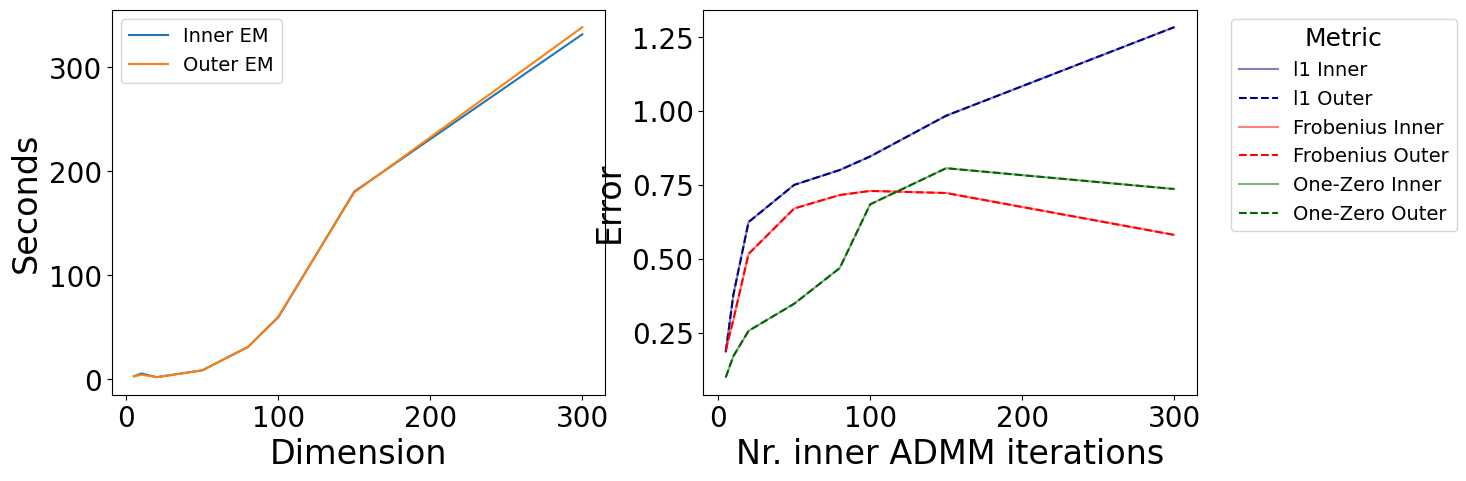

In [22]:


fig, ax = plt.subplots(1,2, figsize = (14,5))

ax[0].plot(ds, time_inner, label  = 'Inner EM')
ax[0].plot(ds, time_outer, label  = 'Outer EM')
ax[0].set_xlabel("Dimension", fontdict = {'fontsize':24})
ax[0].set_ylabel("Seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
#ax[0].set_xticks(0])
legend = ax[0].legend(fontsize = 14)
legend.get_title().set_fontsize('18')

ax[1].plot(ds,l1_inner, label ='l1 Inner', color = "darkblue", alpha = 0.5)
ax[1].plot(ds,l1_outer, label ='l1 Outer', color = "darkblue", linestyle = 'dashed')
ax[1].plot(ds,F_inner, label ='Frobenius Inner', color = "red", alpha = 0.5)
ax[1].plot(ds,F_outer, label ='Frobenius Outer', color = "red", linestyle = 'dashed')
ax[1].plot(ds,zo_inner, label ='One-Zero Inner', color = "darkgreen", alpha = 0.5)
ax[1].plot(ds,zo_outer, label ='One-Zero Outer', color = "darkgreen", linestyle = 'dashed')
#ax[1].plot(nr_admm_its,[np.mean(zo_error[i]) for i in range(len(zo_error))], label ='Zero-One')
#ax[1].plot(nr_admm_its,[np.mean(f_error[i]) for i in range(len(f_error))], label ='Frobenius')
legend = ax[1].legend(title = "Metric",fontsize = 14, bbox_to_anchor = (1.05,1))
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
# ax[1].set_xticks([0,5, 10, 15])
